## Portfolio Exercise: Starbucks
<br>

<img src="https://opj.ca/wp-content/uploads/2018/02/New-Starbucks-Logo-1200x969.jpg" width="200" height="200">
<br>
<br>
 
#### Background Information

The dataset you will be provided in this portfolio exercise was originally used as a take-home assignment provided by Starbucks for their job candidates. The data for this exercise consists of about 120,000 data points split in a 2:1 ratio among training and test files. In the experiment simulated by the data, an advertising promotion was tested to see if it would bring more customers to purchase a specific product priced at $10. Since it costs the company 0.15 to send out each promotion, it would be best to limit that promotion only to those that are most receptive to the promotion. Each data point includes one column indicating whether or not an individual was sent a promotion for the product, and one column indicating whether or not that individual eventually purchased that product. Each individual also has seven additional features associated with them, which are provided abstractly as V1-V7.

#### Optimization Strategy

Your task is to use the training data to understand what patterns in V1-V7 to indicate that a promotion should be provided to a user. Specifically, your goal is to maximize the following metrics:

* **Incremental Response Rate (IRR)** 

IRR depicts how many more customers purchased the product with the promotion, as compared to if they didn't receive the promotion. Mathematically, it's the ratio of the number of purchasers in the promotion group to the total number of customers in the purchasers group (_treatment_) minus the ratio of the number of purchasers in the non-promotional group to the total number of customers in the non-promotional group (_control_).

$$ IRR = \frac{purch_{treat}}{cust_{treat}} - \frac{purch_{ctrl}}{cust_{ctrl}} $$


* **Net Incremental Revenue (NIR)**

NIR depicts how much is made (or lost) by sending out the promotion. Mathematically, this is 10 times the total number of purchasers that received the promotion minus 0.15 times the number of promotions sent out, minus 10 times the number of purchasers who were not given the promotion.

$$ NIR = (10\cdot purch_{treat} - 0.15 \cdot cust_{treat}) - 10 \cdot purch_{ctrl}$$

For a full description of what Starbucks provides to candidates see the [instructions available here](https://drive.google.com/open?id=18klca9Sef1Rs6q8DW4l7o349r8B70qXM).

Below you can find the training data provided.  Explore the data and different optimization strategies.

#### How To Test Your Strategy?

When you feel like you have an optimization strategy, complete the `promotion_strategy` function to pass to the `test_results` function.  
From past data, we know there are four possible outomes:

Table of actual promotion vs. predicted promotion customers:  

<table>
<tr><th></th><th colspan = '2'>Actual</th></tr>
<tr><th>Predicted</th><th>Yes</th><th>No</th></tr>
<tr><th>Yes</th><td>I</td><td>II</td></tr>
<tr><th>No</th><td>III</td><td>IV</td></tr>
</table>

The metrics are only being compared for the individuals we predict should obtain the promotion – that is, quadrants I and II.  Since the first set of individuals that receive the promotion (in the training set) receive it randomly, we can expect that quadrants I and II will have approximately equivalent participants.  

Comparing quadrant I to II then gives an idea of how well your promotion strategy will work in the future. 

Get started by reading in the data below.  See how each variable or combination of variables along with a promotion influences the chance of purchasing.  When you feel like you have a strategy for who should receive a promotion, test your strategy against the test dataset used in the final `test_results` function.

In [54]:
# load in packages
from itertools import combinations
# from test_results import test_results, score
import numpy as np
import pandas as pd
import scipy as sp
import sklearn as sk
from scipy.stats import norm, binom_test
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier, EasyEnsembleClassifier
%matplotlib inline

# load in the data
train_data = pd.read_csv('./training.csv')
train_data.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,1,No,0,2,30.443518,-1.165083,1,1,3,2
1,3,No,0,3,32.159350,-0.645617,2,3,2,2
2,4,No,0,2,30.431659,0.133583,1,1,4,2
3,5,No,0,0,26.588914,-0.212728,2,1,4,2
4,8,Yes,0,3,28.044332,-0.385883,1,1,2,2


In [2]:
train_data.shape

(84534, 10)

In [3]:
train_data.duplicated().sum()

0

In [4]:
train_data.groupby('Promotion')['ID'].count()

Promotion
No     42170
Yes    42364
Name: ID, dtype: int64

In [5]:
train_data.query('Promotion == "Yes"')['purchase'].sum()

721

In [6]:
cust_ctrl = train_data.groupby('Promotion')['ID'].count()[0]
cust_treat = train_data.groupby('Promotion')['ID'].count()[1]
print(cust_ctrl, cust_treat)

42170 42364


In [7]:
purch_ctrl = train_data.query('Promotion == "No"')['purchase'].sum()
purch_treat = train_data.query('Promotion == "Yes"')['purchase'].sum()
print(purch_ctrl , purch_treat)

319 721


## Invariant Metric Sanity Check
###  Hypotheses
$$ H_{0}: cust_{ctrl} = cust_{treat} $$ 
$$ H_{1}: cust_{ctrl} != cust_{treat} $$

### 1. Analytical: Confidence Interval 

In [8]:
# Compute critical z score
def get_z_crit(alpha):
    '''
    Compute critical z score

    Args:
        alpha: Significant level

    Returns: Observed proportion and confidence interval

    '''
    return -norm.ppf(alpha / 2)

# Compute confidence interval
def get_confi_interval(N_ctrl, N_treat, p=0.5, alpha = 0.05):
    '''
    Compute confidence interval for population sanity check

    Args:
        N_ctrl: total number of customers in the non-promotional group (control)
        N_treat: total number of customers in the promotional group (treatment) 

    Returns: Observed proportion and confidence interval

    '''
    se = np.sqrt(p * (1 - p) / (N_ctrl + N_treat))
    moe = se * get_z_crit(alpha)
    lb, ub = p - moe, p + moe

    # Observed proportion
    p_obs = N_treat / (N_ctrl + N_treat)

    print('Observed proportion: {:.4f}'.format(p_obs))
    print('Confidence Interval:[{:.4f},{:.4f}]'.format(lb, ub))

    # Check if the observed proportion falls within the confidence interval
    if (p_obs >= lb) & (p_obs <= ub):
        return print('-> Sanity check passed!')
    else:
        return print('-> Sanity check failed!')

get_confi_interval(cust_ctrl, cust_treat)

Observed proportion: 0.5011
Confidence Interval:[0.4966,0.5034]
-> Sanity check passed!


### 2. Analytical: p_value (Normal and Binomial Distribution)

In [9]:
def get_p_value(N_ctrl, N_treat, p=0.5, alpha = 0.05):
    '''
    Compute p-values for population sanity check

    Args:
        N_ctrl: total number of customers in the non-promotional group (control)
        N_treat: total number of customers in the promotional group (treatment) 

    Returns: z-scores and p-values

    '''

    N_total = N_ctrl + N_treat

    # Using z-Test formula
    se = np.sqrt(p * (1 - p) * N_total)
    # x = N_ctrl
    x = N_treat
    miu = p * N_total
    z = (x - miu) / se
    if z > 0: # x = N_treat
        pval = (1 - norm.cdf(z)) * 2
    else: # x = N_ctrl
        pval = 2 * norm.cdf(z)

    print('z score calculated: {:.4f}'.format(z))
    print('p_value calculated: {:.4f}'.format(pval))

    # Using built-in function

    # ztest
    stat_z, pval_z = sm.stats.proportions_ztest(N_treat, N_total, value = p, alternative = 'two-sided')
    print('z score normal built-in function: {:.4f}'.format(stat_z))
    print('p_value normal built-in function: {:.4f}'.format(pval_z))

    # Assumption: binomial
    pval_binom = binom_test(N_treat, N_total, p = p, alternative = 'two-sided')
    print('p_value binomial built-in function: {:.4f}'.format(pval_binom))

    if pval > alpha:
        return print('-> We fail to reject the null hypothesis, Sanity check passed!')
    else:
        return print('-> We reject the null hypothesis, Sanity check failed!')

get_p_value(cust_ctrl, cust_treat)

z score calculated: 0.6672
p_value calculated: 0.5046
z score normal built-in function: 0.6672
p_value normal built-in function: 0.5046
p_value binomial built-in function: 0.5068
-> We fail to reject the null hypothesis, Sanity check passed!


### 3. Simulation: p_value (Sampling Distribution)

In [10]:
print(cust_ctrl, cust_treat)

42170 42364


In [11]:
def get_p_value_sampling_distribution(N_ctrl, N_treat, n_trials, p = 0.5, alpha = 0.05):
    N_total = N_ctrl + N_treat
    samples = np.random.binomial(N_total, p, n_trials)
    # pval = np.logical_or(samples <= N_treat, samples >= N_ctrl).mean()
    # Important: N_treat is bigger than N_ctrl
    pval = np.logical_or(samples <= N_ctrl, samples >= N_treat).mean()
    print('p_value: {}'.format(pval))

    if pval > alpha:
        return print('-> We fail to reject the null hypothesis, Sanity check passed!')
    else:
        return print('-> We reject the null hypothesis, Sanity check failed!')

get_p_value_sampling_distribution(cust_ctrl, cust_treat, 200000)

p_value: 0.507145
-> We fail to reject the null hypothesis, Sanity check passed!


# Result Analysis: Evaluation Metrics

## Conversion Rate
###  Hypotheses
$$ H_{0}: p_{treat} - p_{ctrl} <= 0 $$ 
$$ H_{1}: p_{treat} - p_{ctrl} > 0 $$

In [12]:
train_data.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,1,No,0,2,30.443518,-1.165083,1,1,3,2
1,3,No,0,3,32.159350,-0.645617,2,3,2,2
2,4,No,0,2,30.431659,0.133583,1,1,4,2
3,5,No,0,0,26.588914,-0.212728,2,1,4,2
4,8,Yes,0,3,28.044332,-0.385883,1,1,2,2


In [13]:
p_ctrl = train_data.query('Promotion == "No"')['purchase'].mean()
p_treat = train_data.query('Promotion == "Yes"')['purchase'].mean()
print(p_ctrl, p_treat)

0.007564619397676073 0.017019167217448776


In [14]:
train_data['purchase'].mean()

0.012302742091939338

### 1. Analytical: p_value (Normal Distribution)

In [15]:
def get_p_value_evaluation(df, N_ctrl, N_treat, alpha = 0.05):
    
    # Formula
    purch_ctrl = df.query('Promotion == "No"')['purchase'].sum()
    purch_treat = df.query('Promotion == "Yes"')['purchase'].sum()

    p_ctrl = df.query('Promotion == "No"')['purchase'].mean()
    p_treat = df.query('Promotion == "Yes"')['purchase'].mean()
    
    p_pool = df['purchase'].mean()

    se_pool = np.sqrt(p_pool * (1 - p_pool)*(1 / N_ctrl + 1 / N_treat))

    z = (p_treat - p_ctrl) / se_pool
    pval = 1 - norm.cdf(z)
    print('z socore: {:.4f}'.format(z))
    print('p_value: {:.4f}'.format(pval))

    # Built in function
    stat_z, pval_z = sm.stats.proportions_ztest([purch_treat, purch_ctrl], [N_treat, N_ctrl], alternative = 'larger')
    print('z socore built in function: {:.4f}'.format(stat_z))
    print('p_value built in function: {:.4f}'.format(pval_z))

    if pval > alpha:
        return print('-> We fail to reject the null hypothesis, with a Type I error rate of {:.0f}%, we do not have enough evidence that the converted rate with promotion is better than the converted rate with non-promotion.'.format(alpha*100))
    else:
        return print('-> We reject the null hypothesis, with a Type I error rate of {:.0f}%, we have enough evidence that the converted rate with promotion is better than the converted rate with non-promotion.'.format(alpha*100))

get_p_value_evaluation(train_data, cust_ctrl, cust_treat)


z socore: 12.4684
p_value: 0.0000
z socore built in function: 12.4684
p_value built in function: 0.0000
-> We reject the null hypothesis, with a Type I error rate of 5%, we have enough evidence that the converted rate with promotion is better than the converted rate with non-promotion.


### 2. Analytical: Effect Size Test

In [16]:
def effect_size(df, N_ctrl, N_treat, dmin, null_diff = 0, alpha = 0.05):
    '''
    Compute confidence interval for converted rate

    Args:
        df: 
        N_ctrl: total number of customers in the non-promotional group (control)
        N_treat: total number of customers in the promotional group (treatment) 
        dmin = Practical significant level (Minimum Detectable Effect)

    Returns: Observed proportion and confidence interval

    '''

    # Observed difference in proportion
    p_ctrl = df.query('Promotion == "No"')['purchase'].mean()
    p_treat = df.query('Promotion == "Yes"')['purchase'].mean()
    obs_diff = p_treat - p_ctrl

    # Compute pooled standard error assuming that both of the variances from the two samples are equal
    p_pool = df['purchase'].mean()

    se_pool = np.sqrt(p_pool * (1 - p_pool) / (N_ctrl + N_treat))
    moe = se_pool * get_z_crit(alpha)

    lb, ub = obs_diff - moe, obs_diff + moe

    # print('Observed difference in proportion: {:.4f}'.format(obs_diff))
    print('Confidence Interval:[{:.4f},{:.4f}]'.format(lb, ub))
    
    # Check if it is statistically significant
    if (null_diff >= lb) & (null_diff <= ub):
        print('-> Difference in proportion under the null (null_diff = 0) is within the range, there is not a statistical significant positive change.')
    else:
        print('-> The confidence interval is far right from the null (null_diff = 0), there is a statistical significant positive change.')
    
    # Check if it is practically significant
    if (dmin >= lb) & (dmin <= ub):
        print('-> With a practical significant level of {}, best guess is there is a practical significant positive change, but there is also possible the change is not practically significant.'.format(dmin))
    elif (-dmin >= lb) & (-dmin <= ub):
        print('-> With a practical significant level of {}, best guess is there is a practical significant negative change, but there is also possible the change is not practically significant. '.format(dmin))
    else:
        print('-> The confidence interval is far right from the practical significant level, there is a practical significant positive change.'.format(dmin))

effect_size(train_data, cust_ctrl, cust_treat, 0.01)


Confidence Interval:[0.0087,0.0102]
-> The confidence interval is far right from the null (null_diff = 0), there is a statistical significant positive change.
-> With a practical significant level of 0.01, best guess is there is a practical significant positive change, but there is also possible the change is not practically significant.


### 3. Simulating from the Null

p_value: 0.0000
-> We reject the null hypothesis, with a Type I error rate of 5%, we have enough evidence that the converted rate with promotion is better than the converted rate with non-promotion.


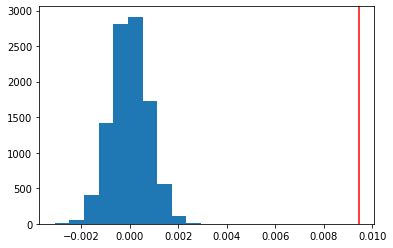

In [17]:
def simulation_evaluation(df, N_ctrl, N_treat, alpha = 0.05):

    # Observed difference in proportion
    p_ctrl = df.query('Promotion == "No"')['purchase'].mean()
    p_treat = df.query('Promotion == "Yes"')['purchase'].mean()
    obs_diff = p_treat - p_ctrl

    # Simulate sampling distribution of the difference in converted rate under the null hypothesis
    p_diffs = []
    # np.random.binomial(n, p, size)
    # n = number of trials
    # p = probability of success of each trial
    # size = tested for how many times
    
    # Assume under the null hypothesis
    # p_treat and p_ctrl both have "true" success rates equal to the converted success rate regardless of promotion
    # p_ctrl = p_treat = p_null
    p_null = df['purchase'].mean()
    converted_treat_simulation = np.random.binomial(N_treat, p_null, size=10000)/N_treat
    converted_ctrl_simulation = np.random.binomial(N_ctrl, p_null, size=10000)/N_ctrl
    p_diffs = converted_treat_simulation - converted_ctrl_simulation
        
    # Convert to numpy array
    p_diffs = np.array(p_diffs)

    # Compute p-value
    pval = (p_diffs > obs_diff).mean()
    print('p_value: {:.4f}'.format(pval))

    plt.hist(p_diffs)
    plt.axvline(x=obs_diff, color = 'red')

    if pval > alpha:
        return print('-> We fail to reject the null hypothesis, with a Type I error rate of {:.0f}%, we do not have enough evidence that the converted rate with promotion is better than the converted rate with non-promotion.'.format(alpha*100))
    else:
        return print('-> We reject the null hypothesis, with a Type I error rate of {:.0f}%, we have enough evidence that the converted rate with promotion is better than the converted rate with non-promotion.'.format(alpha*100))

simulation_evaluation(train_data, cust_ctrl, cust_treat)

> This is expected, but what about the other two more important metrics, IRR and NIR?

# Extra

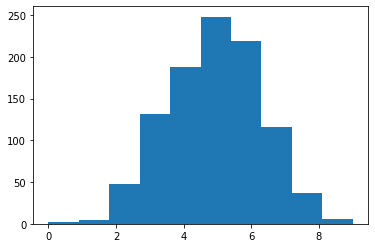

0 0.0009765625
1 0.009765625
2 0.0439453125
3 0.1171875
4 0.205078125
5 0.24609375
6 0.205078125
7 0.1171875
8 0.0439453125
9 0.009765625
10 0.0009765625


In [18]:
from math import factorial

n, p = 10, .5  # number of trials, probability of success each trial
s = np.random.binomial(n, p, 1000)

plt.hist(s)
plt.show()
# Getting 5 successes out of 10 has the highest probability

# To prove: 
for k in range(0,11):
    print(k, factorial(n) / (factorial(k) * factorial(n - k)) * p ** k * (1 - p) ** (n - k))

## Incremental Response Rate
$$ IRR = \frac{purch_{treat}}{cust_{treat}} - \frac{purch_{ctrl}}{cust_{ctrl}} $$

### Hypotheses
$$ H_{0}: IRR <= 0 $$
$$ H_{1}: IRR > 0 $$

### Analytical: Effect Size Test

In [19]:
def effect_size_IRR(df, N_ctrl, N_treat, dmin, IRR_null = 0, alpha = 0.05):
    '''
    Compute confidence interval for converted rate

    Args:
        df: 
        N_ctrl: total number of customers in the non-promotional group (control)
        N_treat: total number of customers in the promotional group (treatment) 
        dmin = Practical significant level (Minimum Detectable Effect)

    Returns: Observed proportion and confidence interval

    '''
    purch_ctrl = df.query('Promotion == "No"')['purchase'].sum()
    purch_treat = df.query('Promotion == "Yes"')['purchase'].sum()

    # Observed IRR
    IRR_obs = purch_treat / N_treat - purch_ctrl / N_ctrl

    # Compute pooled standard error assuming that both of the variances from the two samples are equal
    p_pool = (purch_treat + purch_ctrl) / (N_treat + N_ctrl)
    se_pool = np.sqrt(p_pool * (1 - p_pool) / (N_ctrl + N_treat))
    moe = se_pool * get_z_crit(alpha)

    lb, ub = IRR_obs - moe, IRR_obs + moe

    print('Incremental Response Rate: {:.4f}'.format(IRR_obs))
    print('Confidence Interval: [{:.4f},{:.4f}]'.format(lb, ub))
    
    # Check if it is statistically significant
    if (IRR_null >= lb) & (IRR_null <= ub):
        print('-> Difference in proportion under the null (null_diff = 0) is within the range, there is not a statistical significant positive change.')
    else:
        print('-> The confidence interval is far right from the null (null_diff = 0), there is a statistical significant positive change.')
    
    # Check if it is practically significant
    if (dmin >= lb) & (dmin <= ub):
        print('-> With a practical significant level of {}, best guess is there is a practical significant positive change, but there is also possible the change is not practically significant.'.format(dmin))
    elif (-dmin >= lb) & (-dmin <= ub):
        print('-> With a practical significant level of {}, best guess is there is a practical significant negative change, but there is also possible the change is not practically significant. '.format(dmin))
    else:
        print('-> The confidence interval is far right from the practical significant level, there is a practical significant positive change.'.format(dmin))

effect_size_IRR(train_data, cust_ctrl, cust_treat, 0.01)


Incremental Response Rate: 0.0095
Confidence Interval: [0.0087,0.0102]
-> The confidence interval is far right from the null (null_diff = 0), there is a statistical significant positive change.
-> With a practical significant level of 0.01, best guess is there is a practical significant positive change, but there is also possible the change is not practically significant.


### Net Incremental Reveneu
$$ NIR = (10\cdot purch_{treat} - 0.15 \cdot cust_{treat}) - 10 \cdot purch_{ctrl}$$

### Hypotheses
$$ H_{0}: NIR <= 0 $$
$$ H_{1}: NIR > 0 $$

### Bootstrapping + Sampling Distribution

In [20]:
def calculate_NIR(df):
    cust_ctrl = df.groupby('Promotion')['ID'].count()[0]
    cust_treat = df.groupby('Promotion')['ID'].count()[1]

    purch_ctrl = df.query('Promotion == "No"')['purchase'].sum()
    purch_treat = df.query('Promotion == "Yes"')['purchase'].sum()

    NIR = (10 * purch_treat - 0.15 * cust_treat) - 10 * purch_ctrl

    return NIR

Net Incremental Reveneu: -2334.6000
p_value: 1.0000
-> We fail to reject the null hypothesis, with a Type I error rate of 5%, we do not have enough evidence that the change in NIR is statistically significant.


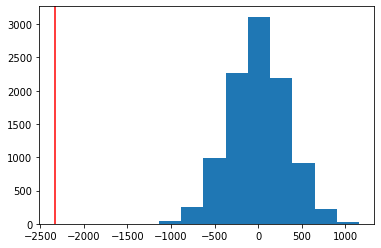

In [21]:
def simulation_evaluation_NIR(df, alpha = 0.05):   

    # Bootstrapping, sampling distribution of the NIR
    sample_NIRs = []
    r = 1000 # Number of trials
    c = df.shape[0] # Sample size

    for _ in range(r):
        bootsample = df.sample(n = c, replace = True)
        sample_NIRs.append(calculate_NIR(bootsample))

    # Simulate the value of NIR under the null hypothesis
    NIR_null = 0 
    null_values = np.random.normal(NIR_null, np.std(sample_NIRs), 10000)

    # Calculate the mean of the simulated NIR values
    NIR_obs = calculate_NIR(df)

    # Convert to numpy array
    null_values = np.array(null_values)

    # Compute p-value
    print('Net Incremental Reveneu: {:.4f}'.format(NIR_obs))
    pval = (null_values > NIR_obs).mean()
    print('p_value: {:.4f}'.format(pval))

    plt.hist(null_values)
    plt.axvline(x=NIR_obs, color = 'red')

    if pval > alpha:
        return print('-> We fail to reject the null hypothesis, with a Type I error rate of {:.0f}%, we do not have enough evidence that the change in NIR is statistically significant.'.format(alpha*100))
    else:
        return print('-> We reject the null hypothesis, with a Type I error rate of {:.0f}%, we have enough evidence that the change in NIR is statistically significant.'.format(alpha*100))

simulation_evaluation_NIR(train_data)

# Uplift Modeling

In [41]:
train_data.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,1,No,0,2,30.443518,-1.165083,1,1,3,2
1,3,No,0,3,32.159350,-0.645617,2,3,2,2
2,4,No,0,2,30.431659,0.133583,1,1,4,2
3,5,No,0,0,26.588914,-0.212728,2,1,4,2
4,8,Yes,0,3,28.044332,-0.385883,1,1,2,2


## Feature Engineering

In [55]:
# only those who made a purchase after receiving a promotion will be assigned a label of 1, 
# while the other individuals will be given a label of 0
# in other words, only getting the best customers that is worth sending promotion to
response = []

for index, row in train_data.iterrows():
    if (row['purchase'] == 1) and (row['Promotion']=='Yes'):
        response.append(1)
    else:
        response.append(0)
        
train_data['response'] = response

## Modeling

In [56]:
X = train_data[['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7']]
y = train_data['response']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [44]:
# define model
clf = RandomForestClassifier(n_estimators=10, class_weight='balanced_subsample')
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(clf, X_train,  y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('RandomForestClassifier')
print('Mean ROC AUC: %.3f' % np.mean(scores))

RandomForestClassifier
Mean ROC AUC: 0.517


In [45]:
# define model
clf = BalancedRandomForestClassifier(n_estimators=10)
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(clf, X_train,  y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('BalancedRandomForestClassifier')
print('Mean ROC AUC: %.3f' % np.mean(scores))

BalancedRandomForestClassifier
Mean ROC AUC: 0.611


In [46]:
# define model
clf = EasyEnsembleClassifier(n_estimators=10)
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(clf, X_train,  y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('EasyEnsembleClassifier')
print('Mean ROC AUC: %.3f' % np.mean(scores))

EasyEnsembleClassifier
Mean ROC AUC: 0.637


In [57]:
def build_model():
    # specify parameters for grid search
    parameters = {
    'n_estimators': [10, 20],
    'replacement': [False, True],
    'sampling_strategy': ['auto', 'all']
    }
    # create grid search object
    cv = GridSearchCV(estimator = EasyEnsembleClassifier(), param_grid = parameters, cv = 3, n_jobs=-1, verbose=2)

    return cv

In [58]:
model = build_model()           
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:  1.0min finished


# Model Evaluation

## Training Set Evaluation

In [59]:
pd.Series(y_pred).value_counts()

0    11597
1     9537
dtype: int64

In [60]:
confusion_matrix(y_test, y_pred)

array([[11544,  9418],
       [   53,   119]])

In [61]:
# evaluate classification model
def evaluate_model(y_test, y_pred):
    clsReport = classification_report(y_test, y_pred, zero_division=1)
    print("Classification report:", clsReport)

evaluate_model(y_test, y_pred)

Classification report:               precision    recall  f1-score   support

           0       1.00      0.55      0.71     20962
           1       0.01      0.69      0.02       172

    accuracy                           0.55     21134
   macro avg       0.50      0.62      0.37     21134
weighted avg       0.99      0.55      0.70     21134



## Test Set Evaluation

In [52]:
def promotion_strategy(df):
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should recieve a promotion 
                   should be the length of df.shape[0]
                
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    OUTPUT: promotion_df
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''

    y_pred = model.predict(df)
    promotion = []
    for i in y_pred:
        if i == 1:
            promotion.append('Yes')
        else:
            promotion.append('No')
    promotion_df = np.asarray(promotion)
    
    return promotion_df 

def score(df, promo_pred_col = 'Promotion'):
    n_treat       = df.loc[df[promo_pred_col] == 'Yes',:].shape[0]
    n_control     = df.loc[df[promo_pred_col] == 'No',:].shape[0]
    n_treat_purch = df.loc[df[promo_pred_col] == 'Yes', 'purchase'].sum()
    n_ctrl_purch  = df.loc[df[promo_pred_col] == 'No', 'purchase'].sum()
    irr = n_treat_purch / n_treat - n_ctrl_purch / n_control
    nir = 10 * n_treat_purch - 0.15 * n_treat - 10 * n_ctrl_purch
    return (irr, nir)
    

def test_results(promotion_strategy):
    test_data = pd.read_csv('Test.csv')
    df = test_data[['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7']]
    promos = promotion_strategy(df)
    
    # Results without modeling
    score_df_baseline = train_data
    irr_base, nir_base = score(score_df_baseline)

    # Results with modeling
    score_df_uplift = test_data.iloc[np.where(promos == 'Yes')]    # Only select the best customers, whom are predicted to have positive response due to promotion
    irr, nir = score(score_df_uplift)
    print("Nice job!  See how well your strategy worked on our test data below!")
    print()
    print('Your irr without strategy is {:0.4f}.'.format(irr_base))
    print('Your irr with this strategy is {:0.4f}.'.format(irr))
    print()
    print('Your nir without strategy is {:0.2f}.'.format(nir_base))
    print('Your nir with this strategy is {:0.2f}.'.format(nir))
    
    print("We came up with a model with an irr of {} and an nir of {} on the test set.\n\n How did you do?".format(0.0188, 189.45))
    return irr, nir

In [53]:
# This will test your results, and provide you back some information 
# on how well your promotion_strategy will work in practice

test_results(promotion_strategy)

Nice job!  See how well your strategy worked on our test data below!

Your irr without strategy is 0.0095.
Your irr with this strategy is 0.0195.

Your nir without strategy is -2334.60.
Your nir with this strategy is 388.95.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


(0.0194930150042329, 388.95000000000005)